In [1]:
# analyze all the pythia experiments
import torch
import matplotlib.pyplot as plt

In [2]:
# models = ['410m', '12b', '2.8b', '70m']
models = ['70M', '410M', '2.8B', '12B']
file_postfix = ['3', '0-1', '2', '1']

In [3]:
data = [torch.load(f'../outputs/pythia-logit-{postfix}.pt',weights_only=False) for postfix in file_postfix]
loss = [d['loss'] for d in data]
logit_std = [d['logit_std'] for d in data]

loss[1] = loss[1][7:]
logit_std[1] = logit_std[1][7:]

In [4]:
from scipy import optimize
import numpy as np

def residuals(x, c_l, alpha_l, L0):
    return np.log((c_l / (x ** alpha_l) + L0))

In [5]:
steps = [128, 256, 512, 1000, 2000, 3000, 6000, 12000, 16000, 32000, 48000, 79000, 143000]
def lr_scheduler(step, total_steps = 143000):
    # linear warmup 0.01 + cosine decay to 0.1 max lr
    step = torch.tensor(step)
    if step < total_steps * 0.01:
        return step / (total_steps * 0.01)
    else:
        progress = (step - total_steps * 0.01) / (total_steps * 0.99)
        return 0.5 * (1.0 + torch.cos(torch.pi * progress)) * 0.9 + 0.1

lrs = torch.tensor([lr_scheduler(step) for step in range(1,143001)])
tau = torch.tensor([lrs[:step].sum() for step in steps])
del lrs

steps = torch.tensor(steps)

In [6]:
max_lrs = [1e-3, 3e-4, 1.6e-4, 1.2e-4]

In [7]:
c_taus = []
alpha_taus = []
alpha_std_taus = []
L0_taus = []

for i in range(4):
    if i == 0:
        fitout = optimize.curve_fit(residuals, tau[1:-2].numpy(), 
                                    loss[i].log()[1:-2].numpy(), 
                                    maxfev=100000, p0=[1,0.33,loss[i][-1].item()],
                                            bounds = ([0,0,0], [np.inf,np.inf,loss[i][-1].item()]))
    else:
        fitout = optimize.curve_fit(residuals, tau[2:].numpy(), 
                                    loss[i].log()[2:].numpy(), 
                                    maxfev=100000, p0=[1,0.33,loss[i][-1].item()],
                                            bounds = ([0,0,0], [np.inf,np.inf,loss[i][-1].item()]))
    c_taus.append(fitout[0][0])
    alpha_taus.append(fitout[0][1])
    alpha_std_taus.append(np.sqrt(np.diag(fitout[1]))[1])
    L0_taus.append(fitout[0][2])

Text(0, 0.5, 'Test loss')

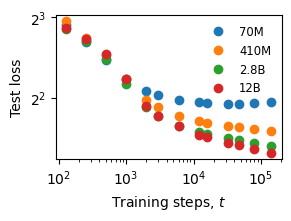

In [25]:
plt.figure(figsize=(2.8,2.1), constrained_layout=True)
for i in range(4):
    plt.plot(steps.numpy(), loss[i].numpy(), 'o',label=models[i])
plt.xscale('log')
plt.yscale('log',base = 2)
plt.legend(frameon=False, fontsize = 'small')
plt.xlabel(r'Training steps, $t$')
plt.ylabel('Test loss')

Text(0, 0.5, 'Test loss')

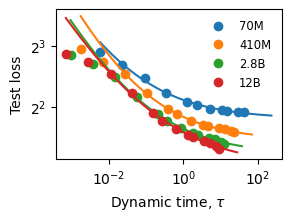

In [22]:
plt.figure(figsize=(2.8,2.1), constrained_layout=True)
plot_x = torch.logspace(torch.log10(tau[0]), torch.log10(tau[-1]*3), steps=100)
plt.plot(tau[:-2].numpy() * max_lrs[0], loss[0][:-2].numpy(), 'o', label=models[0], color = 'C0')
plt.plot(plot_x.numpy() * max_lrs[0], 
         (c_taus[0] / (plot_x.numpy() ** alpha_taus[0]) + L0_taus[0]), 
         '-', color = 'C0')
for i in range(1,4):
    plt.plot(tau.numpy() * max_lrs[i], loss[i].numpy(), 'o', label=models[i], color = f'C{i}')
    plt.plot(plot_x.numpy() * max_lrs[i], 
             (c_taus[i] / (plot_x.numpy() ** alpha_taus[i]) + L0_taus[i]), 
             '-', color = f'C{i}')

plt.xscale('log')
plt.yscale('log',base = 2)
plt.legend(frameon=False,fontsize = 'small')
plt.xlabel(r'Dynamic time, $\tau$')
plt.ylabel('Test loss')

In [25]:
alpha_taus, alpha_std_taus

([0.34071961515447385,
  0.3670317571265018,
  0.33744748310751993,
  0.3073649904236741],
 [0.02781450415735331,
  0.01289855974771548,
  0.012964239150829605,
  0.016449714708779192])

Text(0, 0.5, 'Test loss (training part)')

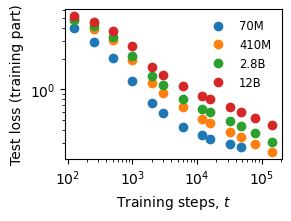

In [ ]:
plt.figure(figsize=(2.8,2.1), constrained_layout=True)
plt.plot(steps[:-2], loss[0][:-2].numpy() - L0_taus[0], 'o', label=models[0])
for i in range(1,4):
    plt.plot(steps, loss[i].numpy() - L0_taus[i], 'o', label=models[i])

plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False, fontsize = 'small')
plt.xlabel(r'Training steps, $t$')
plt.ylabel('Test loss (training part)')

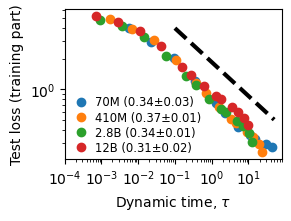

In [71]:
plt.figure(figsize=(2.8,2.1), constrained_layout=True)
plt.plot(tau[:-2].numpy() * max_lrs[0], loss[0][:-2].numpy() - L0_taus[0], 'o', label=models[0]+f' ({alpha_taus[0]:.2f}±{alpha_std_taus[0]:.2f})')
for i in range(1,4):
    plt.plot(tau.numpy() * max_lrs[i], loss[i].numpy() - L0_taus[i], 'o', label=models[i]+f' ({alpha_taus[i]:.2f}±{alpha_std_taus[i]:.2f})')
plt.plot([1e-1,5e+1], [4, 4 / (5e+2)**(1/3)], 'k--', linewidth=3)
plt.legend(frameon=False, fontsize = 'small', labelspacing=0.2, handletextpad=0.2, borderaxespad=0)
plt.xlim(1e-4, 8e+1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Dynamic time, $\tau$')
plt.ylabel('Test loss (training part)')
plt.savefig('../figures/pythia-losses.pdf')

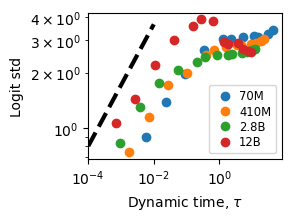

In [ ]:
plt.figure(figsize=(2.8,2.1), constrained_layout=True)
plt.plot(tau[:-2].numpy() * max_lrs[0], logit_std[0][:-2].numpy(), 'o', label=models[0])
for i in range(1,4):
    plt.plot(tau.numpy() * max_lrs[i], logit_std[i].numpy(), 'o', label=models[i])
plt.plot([1e-4,1e-2], [8e-1, 8e-1 * (1e+2)**(0.33)], 'k--', linewidth=3)
plt.legend(fontsize = 'small', labelspacing=0.2, handletextpad=0.2, borderaxespad=0.5)
plt.xlim(1e-4, 8e+1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Dynamic time, $\tau$')
plt.ylabel('Logit std')
plt.savefig('../figures/pythia-logits.pdf')